In [0]:
import os
import zipfile
import tensorflow as tf
#from tensorflow.keras import Model
#from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

--2019-11-10 15:01:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   156MB/s    in 0.5s    

2019-11-10 15:01:14 (156 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

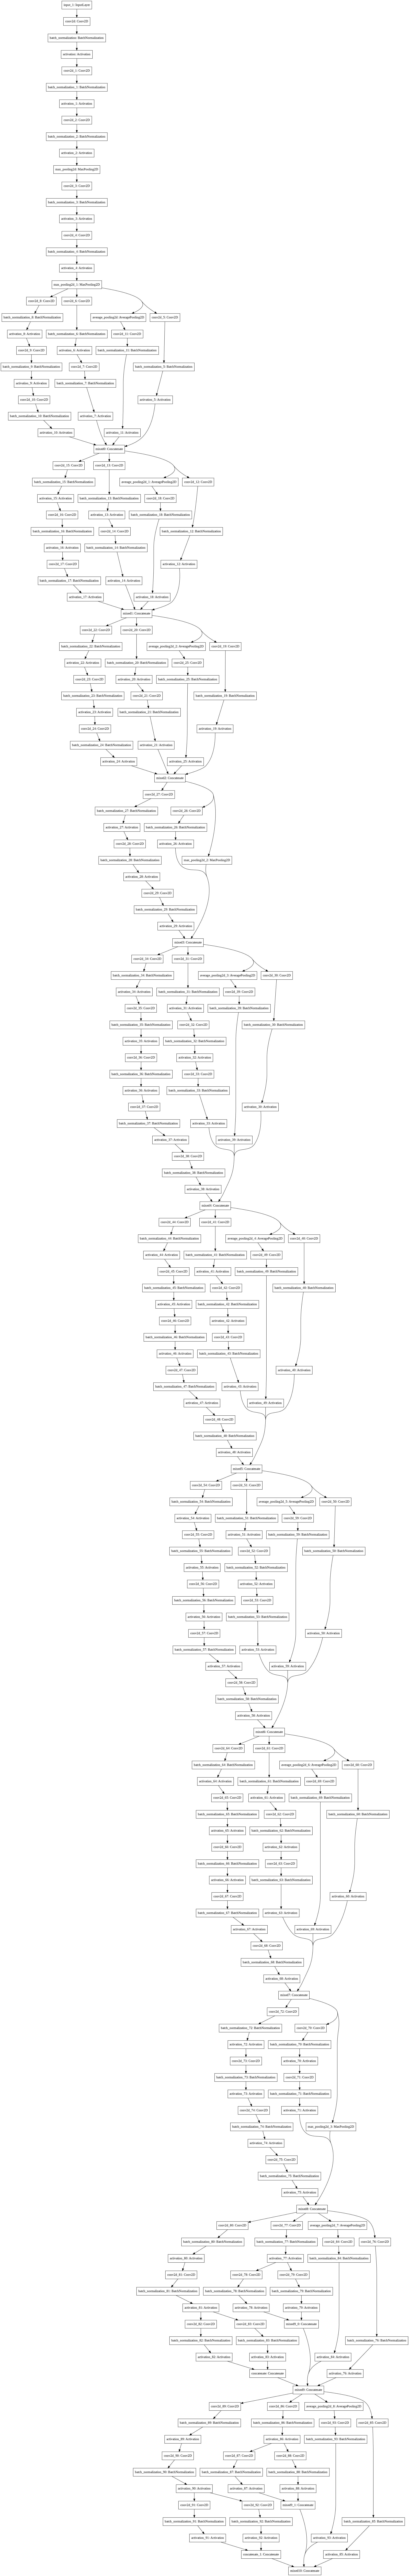

In [5]:
tf.keras.utils.plot_model(pre_trained_model, to_file='pre_trained_model.png')

In [6]:
last_layer = pre_trained_model.get_layer('mixed7') # try with mixed6, mixed8, mixed9, mixed10 (final)
print('new last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
# Flatten the output layer to 1 dimension
X = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
X = tf.keras.layers.Dense(1024, 
                          activation='relu')(X)
# Add a dropout rate of 0.2
X = tf.keras.layers.Dropout(0.2)(X)                  
# Add a final sigmoid layer for classification
X = tf.keras.layers.Dense(1, 
                          activation='sigmoid')(X)           

model = tf.keras.Model(pre_trained_model.input, X) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-11-10 15:05:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 2a00:1450:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   232MB/s    in 0.3s    

2019-11-10 15:05:24 (232 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [14]:
# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print('number of training cat pix', len(train_cat_fnames))
print('number of training dog pix', len(train_dog_fnames))

validation_cat_fnames = os.listdir(validation_cats_dir)
validation_dog_fnames = os.listdir(validation_dogs_dir)

print('number of validation cat pix', len(validation_cat_fnames))
print('number of validation dog pix', len(validation_dog_fnames))

number of training cat pix 1000
number of training dog pix 1000
number of validation cat pix 500
number of validation dog pix 500


In [15]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20, # cf. below: 20x100 steps = 2000 pix
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,  # cf. below: 20x50 steps = 1000 pix
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
history = {}

In [23]:
for i in range(60):
  print()
  print('epoch:', i)
  print()
  tmp = model.fit_generator(
              train_generator,
              validation_data = validation_generator,
              steps_per_epoch = 100,
              epochs = 1,
              validation_steps = 50,
              verbose = 1)
  if not history:
    history = tmp
  else:
    history.history['acc'] += tmp.history['acc']
    history.history['val_acc'] += tmp.history['val_acc']
    history.history['loss'] += tmp.history['loss']
    history.history['val_loss'] += tmp.history['val_loss']


epoch: 0

100/100 [==============================] - 24s 245ms/step - loss: 0.2373 - acc: 0.9110 - val_loss: 0.3151 - val_acc: 0.9650

epoch: 1

100/100 [==============================] - 24s 242ms/step - loss: 0.2210 - acc: 0.9150 - val_loss: 0.3402 - val_acc: 0.9630

epoch: 2

100/100 [==============================] - 24s 238ms/step - loss: 0.2284 - acc: 0.9060 - val_loss: 0.3972 - val_acc: 0.9580

epoch: 3

100/100 [==============================] - 25s 245ms/step - loss: 0.2388 - acc: 0.9085 - val_loss: 0.3764 - val_acc: 0.9600

epoch: 4

100/100 [==============================] - 24s 242ms/step - loss: 0.2422 - acc: 0.9040 - val_loss: 0.3924 - val_acc: 0.9590

epoch: 5

100/100 [==============================] - 25s 251ms/step - loss: 0.2387 - acc: 0.9155 - val_loss: 0.5349 - val_acc: 0.9570

epoch: 6

100/100 [==============================] - 24s 245ms/step - loss: 0.2318 - acc: 0.9130 - val_loss: 0.4137 - val_acc: 0.9610

epoch: 7

100/100 [==============================] - 2

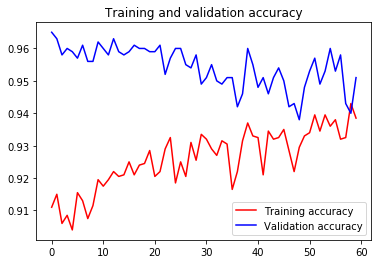

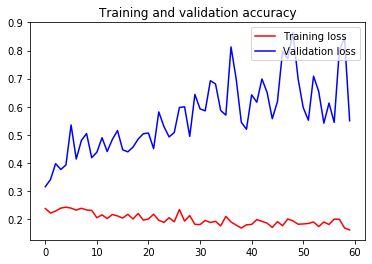

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=1)

plt.show()